# Benchmark the feature finding approach against conventional ones

1) Use jailbreakbench/harmbench/adv bench to eval the performance. (100 examples)
2) Compare CE loss on Pile/Alpaca
3) Compare capability perf on GSM8K/MMLU/ARC

1)- Compare against just topk cosine sim, topk act diff, linear attribution (SMarks) - ensure all feature set are same size

2/3)- Compare against w/o clamping


In [1]:
from utils.utils import *
from utils.plot_utils import *
from utils.data_utils import *
from utils.eval_refusal import *
from utils.attribution_utils import *
from utils.model_utils import *
from tqdm import tqdm
from collections import defaultdict
import os
import numpy as np
import torch.nn.functional as F
import pickle
from copy import deepcopy
import requests
import pandas as pd

with open('openai_key.txt','r') as f:
    openai_key = f.read().strip()
os.environ['OPENAI_API_KEY'] = openai_key

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.set_grad_enabled(False) # rmb set to true for grads

In [2]:
# Load model and SAE

device = 'cuda:1'
torch_dtype = torch.bfloat16
model_name = "gemma-2b"
# model_name = 'llama'
model = load_tl_model(model_name,device = device, torch_dtype = torch_dtype)
num_sae_layer = model.cfg.n_layers
saes = load_sae(model_name,num_sae_layer,device=device, torch_dtype=torch_dtype,split_device = False)
size = model_sizes[model_name]
model.model_name = model_name


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


# Neuronpedia

In [1]:
from IPython.display import IFrame
saes_descriptions = defaultdict(defaultdict)
comps = ['res']

if 'gemma' in model_name.lower(): # llama cant export for some reason, only can take ad-hoc feature
    
    neuropedia_path = f'{model_name}_res_neuropedia.pkl'
    if not os.path.exists(neuropedia_path): # takes 5 min, just cache them for later use.
        for layer in tqdm(range(num_sae_layer),total = num_sae_layer):
            for comp in comps:
                url = f"https://www.neuronpedia.org/api/explanation/export?modelId=gemma-2-{model_name.split('-')[-1]}&saeId={layer}-gemmascope-{comp}-{size}"
                headers = {"Content-Type": "application/json"}

                response = requests.get(url, headers=headers)
                data = response.json()
                explanations_df = pd.DataFrame(data)
                # # rename index to "feature"
                explanations_df.rename(columns={"index": "feature"}, inplace=True)
                explanations_df["feature"] = explanations_df["feature"].astype(int)
                explanations_df["description"] = explanations_df["description"].apply(
                    lambda x: x.lower()
                )
                saes_descriptions[layer][comp] = explanations_df
        with open(neuropedia_path,'wb') as f:
            pickle.dump(saes_descriptions,f)
    else:
        with open(neuropedia_path,'rb') as f:
            saes_descriptions = pickle.load(f)

def get_feat_description(feat,layer,comp = 'res'): # get the description given feature and layer
    if 'gemma' in model_name:
        df = saes_descriptions[layer][comp]
        try:
            return df[df["feature"] == feat]["description"].iloc[0]
        except:
            return "No description found"
    else:
        api_url = "https://www.neuronpedia.org/api/feature/llama3.1-8b/{l}-llamascope-res-{size}/{f}"
        try:
            data = requests.get(api_url.format(l=layer,f=feat,size= size)).json()
            return data["explanations"][0]["description"]
        except:
            return "No description found"

html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(model = "gemma-2-2b", layer=0, feature_idx=0):
    html_ = html_template.format(model, f'{layer}-{"gemmascope" if "gemma" in model else "llamascope"}-res-{size}', feature_idx)
    return html_

def get_max_act_approx(layer, feature_idx): # some fn to get the max act of a feature
    url = f"https://www.neuronpedia.org/api/feature/{'gemma-2-2b' if 'gemma' in model_name else 'llama3.1-8b'}/{layer}-{'gemmascope' if 'gemma' in model_name else 'llamascope'}-res-{size}/{feature_idx}"

    headers = {"X-Api-Key": "YOUR_SECRET_TOKEN"}

    response = requests.get(url, headers=headers)

    return response.json()['maxActApprox']

In [2]:
# Load hb classifier
hb_model = load_harmbench_classifier(use_vllm=True)

INFO 05-30 12:01:37 __init__.py:190] Automatically detected platform cuda.
INFO 05-30 12:01:47 config.py:542] This model supports multiple tasks: {'embed', 'score', 'reward', 'classify', 'generate'}. Defaulting to 'generate'.
INFO 05-30 12:01:47 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='cais/HarmBench-Llama-2-13b-cls', speculative_config=None, tokenizer='cais/HarmBench-Llama-2-13b-cls', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute

Loading safetensors checkpoint shards:   0% Completed | 0/6 [00:00<?, ?it/s]


INFO 05-30 12:01:54 model_runner.py:1115] Loading model weights took 24.2836 GB
INFO 05-30 12:01:55 worker.py:267] Memory profiling takes 0.61 seconds
INFO 05-30 12:01:55 worker.py:267] the current vLLM instance can use total_gpu_memory (79.33GiB) x gpu_memory_utilization (0.40) = 31.73GiB
INFO 05-30 12:01:55 worker.py:267] model weights take 24.28GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 0.34GiB; the rest of the memory reserved for KV Cache is 6.97GiB.
INFO 05-30 12:01:55 executor_base.py:110] # CUDA blocks: 570, # CPU blocks: 327
INFO 05-30 12:01:55 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 4.45x
INFO 05-30 12:01:56 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████████████████████████████████████████████████████████████| 35/35 [00:18<00:00,  1.88it/s]

INFO 05-30 12:02:15 model_runner.py:1562] Graph capturing finished in 19 secs, took 1.15 GiB
INFO 05-30 12:02:15 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 21.15 seconds


# Load harmless (Alpaca) and harmful

In [5]:
bz = 64 if 'gemma' in model_name else 50
N_test = 100
harmful_train, harmless_train, _, harmless_val = load_refusal_datasets(val_size=200) # get 200 and filter out so we can use it later for validation

is_base_harmless,base_harmless_logit = batch_single(harmless_train,model,eval_refusal=True,avg_samples=False)
base_harmless_acc = np.mean(is_base_harmless)
print (f'Base refusal on harmless dataset acc (single token): {base_harmless_acc:.2f}')

is_base_harmful,_ = batch_single(harmful_train,model,eval_refusal=True,avg_samples=False)
harmful_train = [x for x,y in zip(harmful_train,is_base_harmful) if y]
print (f'Filtered harmful samples: {len(harmful_train)}')

is_val_refusal,_ = batch_single(harmless_val,model,eval_refusal=True,avg_samples=False)
# filter out
harmless_train = [x for x,y in zip(harmless_train,is_base_harmless) if not y]
harmless_val = [x for x,y in zip(harmless_val,is_val_refusal) if not y]

print (f'Filtered harmless samples: {len(harmless_train)}, Val harmless samples: {len(harmless_val)}')

## load jb bench/harmbench/advbench
harm_ds_names = ['harmbench_test','jailbreakbench','advbench']
harm_ds = {name:load_all_dataset(name,instructions_only=True)[:N_test] for name in harm_ds_names}

bm_dir = f'cache/benchmarks'
os.makedirs(bm_dir,exist_ok=True)
bm_path = os.path.join(bm_dir,f'{model_name}_base.pkl')

# base refusal perf. (use harmbench classifier)
if not os.path.exists(bm_path):
    base_harm_safety = {}
    base_harm_refusal = {}
    base_resps = {}
    for harm_name,ds in tqdm(harm_ds.items(),total = len(harm_ds)):
        base_resp = batch_generate(ds,model,bz = bz)
        base_resps[harm_name] = base_resp
        base_jb = harmbench_judge(ds,base_resp,hb_model)
        base_refusal = np.mean([substring_matching_judge_fn(x) for x in base_resp])
        print (f'Base refusal on {harm_name} jb: {base_jb:.2f}, refusal: {base_refusal:.2f}')
        base_harm_safety[harm_name] = base_jb
        base_harm_refusal[harm_name] = base_refusal

    with open(bm_path,'wb') as f:
        pickle.dump({'jb':base_harm_safety,'refusal':base_harm_refusal,'base_resps':base_resps},f)
else:
    with open(bm_path,'rb') as f:
        data = pickle.load(f)
        base_harm_safety = data['jb']
        base_harm_refusal = data['refusal']
        base_resps = data['base_resps']

Base refusal on harmless dataset acc (single token): 0.01
Filtered harmful samples: 126
Filtered harmless samples: 127, Val harmless samples: 197


 33%|███████████████████████████████████████                                                                              | 1/3 [00:36<01:12, 36.38s/it]

Base refusal on harmbench_test jb: 0.00, refusal: 1.00


 67%|██████████████████████████████████████████████████████████████████████████████                                       | 2/3 [01:12<00:36, 36.44s/it]

Base refusal on jailbreakbench jb: 0.01, refusal: 0.97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:49<00:00, 36.39s/it]

Base refusal on advbench jb: 0.00, refusal: 1.00


# Activation Steering Perf

In [6]:
bm_path = os.path.join(bm_dir,f'{model_name}_steer.pkl')
best_layer = {'gemma-2b':15,'llama':11}[model_name] # what we gathered from CatQA - should generalize well
steering_vec = {k: get_steering_vec(ds,harmless_train[:len(ds)],model) for k,ds in harm_ds.items()}

train_steer_vec = get_steering_vec(harmful_train,harmless_train[:len(harmful_train)],model) # we use this to sweep hp

if not os.path.exists(bm_path):
    steer_harm_jb = {}
    steer_harm_refusal = {}
    steer_resps = {}
    for k,ds in harm_ds.items():
        steer_resp = batch_generate(ds,model,bz = bz,steering_fn = 'vec',steering_vec=steering_vec[k][best_layer])
        steer_resps[k] = steer_resp
        steer_harm_jb[k] = harmbench_judge(ds,steer_resp,hb_model)
        steer_harm_refusal[k] = np.mean([substring_matching_judge_fn(x) for x in steer_resp])
        print (f'Steering vec on {k} jb: {steer_harm_jb[k]:.2f}, refusal: {steer_harm_refusal[k]:.2f}')

    with open(bm_path,'wb') as f:
        pickle.dump({'jb':steer_harm_jb,'refusal':steer_harm_refusal,'steer_resps':steer_resps},f)
else:
    with open(bm_path,'rb') as f:
        data = pickle.load(f)
        steer_harm_jb = data['jb']
        steer_harm_refusal = data['refusal']
        steer_resps = data['steer_resps']

Steering vec on harmbench_test jb: 0.86, refusal: 0.01
Steering vec on jailbreakbench jb: 0.83, refusal: 0.00
Steering vec on advbench jb: 0.86, refusal: 0.00


In [ ]:
# do linear attribution (for smarks) we also need to use this for our method
la_bz = 5 if 'gemma-2b' in model_name else 3
harm_attr =  {}
for harm_name,ds in tqdm(harm_ds.items(),total = len(harm_ds)):
    all_attr = []
    for i in range(0,len(ds),la_bz):
        attr,_,_ = linear_attribution(model,saes,ds[i:i+la_bz],steering_vec = steering_vec[harm_name][best_layer],interpolate_steps=10,ind_jailbreak=True)
        all_attr.append(attr)
    harm_attr[harm_name] = pad_sequence_3d(*all_attr)

# ## Get for train set as well for HP search (if doing HP else comment out)
train_attr = []
for i in range(0,len(harmful_train),la_bz):
    attr,_,_ = linear_attribution(model,saes,harmful_train[i:i+la_bz],steering_vec = train_steer_vec[best_layer],interpolate_steps=10,ind_jailbreak=False)
    train_attr.append(attr)
train_attr = pad_sequence_3d(*train_attr)

  0%|                                                                                                                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

# HP search (optional)

In [ ]:
topk_feat_layer = 10

if 'gemma-2b' in model_name:
    topk_common = range(10,60,10) 
else:
    topk_common = range(10,35,5)

# clamp_val = -3 if 'gemma-2b' in model_name else -1
clamp_range = [0,-1,-2,-3]
hp_scores = []
topk_feats = topk_feat_sim(saes,train_steer_vec[best_layer],topk_feat_layer)

for clamp_val in tqdm(clamp_range,total = len(clamp_range)):
    for topk_c in topk_common:
        feat_dict = find_features(model,harmful_train,train_attr,topk_feats,topk=topk_c)['feat_dict']
        sae_gen = batch_generate(harmful_train,model,bz,saes = saes,steering_fn = 'sae',circuit = feat_dict,fn_kwargs = {'val': clamp_val,'ind':True,'multiply':True},max_new_tokens=150)
        sae_jb = harmbench_judge(harmful_train,sae_gen,hb_model)
        hp_scores.append(sae_jb)

hp_scores = np.array(hp_scores).reshape(len(clamp_range),len(topk_common))
y_ticks = list(str(x) for x in clamp_range)
x_ticks = list(str(x) for x in topk_common)
plot_heatmap(hp_scores,x_ticks,y_ticks,xlabel = 'Top K Features',ylabel = 'Clamp Val',title = 'Safety Score')

# Get the feature set for the baselines

In [ ]:
topk = 20  # K^*
topk_feat_layer = 10 # K
clamp_val = -3 if 'gemma-2b' in model_name else -1 # c
baseline_feats = defaultdict(dict)
for harm_name,ds in tqdm(harm_ds.items(),total = len(harm_ds)):
    # 1) Baseline 1 (topk feature with direction using cosine similarity)
    cs_feats = topk_feat_from_cosine(steering_vec[harm_name][best_layer],saes,topk) 
    baseline_feats['cs'][harm_name] = cs_feats

    # baseline 2 (topk feature using act diff between harmful and harmless)
    act_feats = topk_feat_from_act_diff(ds,harmless_train,model,saes,topk,avg_seq='max')
    baseline_feats['act'][harm_name] = act_feats

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:53<00:00, 17.86s/it]


In [14]:
## Baseline 3 (topk feature using linear attribution)
global_feat_dict = defaultdict(dict)

for harm_name,attr in harm_attr.items():
    la_feats = defaultdict(list)
    avg_attr = torch.stack([v.mean(1) for k,v in sorted(attr.items(),key= lambda x: x[0])]).permute(1, 0, 2) # [bz layer feat] 
    for sample_idx in range(len(avg_attr)):
        sample_feats = defaultdict(list)
        topk_layers,topk_feats = topk2d(avg_attr[sample_idx],topk)
        for l,f in zip(topk_layers,topk_feats):
            sample_feats[l.item()].append(f.item())
        for l,feats in sample_feats.items():
            la_feats[l].append(feats) # is gonna be a list of lists of len dataset

    global_attr = avg_attr.mean(0) # [layer,feat]
    topk_layers,topk_feats = topk2d(global_attr,topk)
        
    global_la_f =  [(l,f) for l,f in zip(topk_layers.tolist(),topk_feats.tolist())]
    global_la_feat_dict = defaultdict(list)
    for l,f in global_la_f:
        global_la_feat_dict[l].append(f)

    baseline_feats['la'][harm_name] = la_feats
    global_feat_dict['la'][harm_name] = global_la_feat_dict
    
    # Our approach
    topk_feats_dict = topk_feat_sim(saes,steering_vec[harm_name][best_layer],topk_feat_layer)
    feature_set_stuff = find_features(model,harm_ds[harm_name],attr,topk_feats_dict,topk=topk)
    global_ours_feats = feature_set_stuff['global_feat_list']
    global_ours_feat_dict = defaultdict(list)
    for l,f in global_ours_feats:
        global_ours_feat_dict[l].append(f)

    baseline_feats['our'][harm_name] = feature_set_stuff['feat_dict']
    global_feat_dict['our'][harm_name] = global_ours_feat_dict


# 1) Benchmark

In [7]:
bm_path = os.path.join(bm_dir,f'{model_name}_baseline.pkl')
if not os.path.exists(bm_path):
    fn_kwargs = {'val':clamp_val,'multiply':True}
    baseline_jb_scores = defaultdict(dict)
    baseline_refusal_scores = defaultdict(dict)
    for harm_name,ds in tqdm(harm_ds.items(),total = len(harm_ds)): # over all harmful datasets
        for baseline_name in baseline_feats.keys(): # over all baselines
            b_feats = baseline_feats[baseline_name][harm_name]
            if baseline_name in ['cs','act']:
                fn_kwargs['ind']=False # is shared across samples
            else:
                fn_kwargs['ind']=True
            baseline_resp = batch_generate(ds,model,bz = bz,saes=saes,steering_fn = 'sae',circuit = b_feats,fn_kwargs = fn_kwargs)
            baseline_jb = harmbench_judge(ds,baseline_resp,hb_model)
            baseline_jb_scores[harm_name][baseline_name] = baseline_jb
            baseline_refusal_scores[harm_name][baseline_name]= np.mean([substring_matching_judge_fn(x) for x in baseline_resp])
            print (f'Baseline ({baseline_name}) on {harm_name} JB: {baseline_jb_scores[harm_name][baseline_name]:.2f}')

    # save it 
    bm_path = os.path.join(bm_dir,f'{model_name}_baseline.pkl')
    with open(bm_path,'wb') as f:
        pickle.dump({'jb':baseline_jb_scores,'refusal':baseline_refusal_scores},f)
else:
    with open(bm_path,'rb') as f:
        baseline_bench = pickle.load(f)
    baseline_jb_scores = baseline_bench['jb']
    baseline_refusal_scores = baseline_bench['refusal']

In [ ]:
# sort the scores
combined_safety_scores = deepcopy(baseline_jb_scores)
for k,v in base_harm_safety.items():
    combined_safety_scores[k]['base'] = v
for k,v in steer_harm_jb.items():
    combined_safety_scores[k]['steer'] = v

new_combined_safety_scores = defaultdict(dict)
for k,v in combined_safety_scores.items():
    for kk,vv in v.items():
        new_combined_safety_scores[kk][k] = vv
    
combined_safety_scores = new_combined_safety_scores
for k,v in combined_safety_scores.items():
    print (f"{k}: {v}")

cs: {'harmbench_test': 0.1, 'jailbreakbench': 0.13, 'advbench': 0.04}
act: {'harmbench_test': 0.12, 'jailbreakbench': 0.26, 'advbench': 0.44}
la: {'harmbench_test': 0.27, 'jailbreakbench': 0.26, 'advbench': 0.29}
our: {'harmbench_test': 0.72, 'jailbreakbench': 0.57, 'advbench': 0.82}
base: {'harmbench_test': 0.0, 'jailbreakbench': 0.01, 'advbench': 0.0}
steer: {'harmbench_test': 0.86, 'jailbreakbench': 0.83, 'advbench': 0.86}


# Plot Single

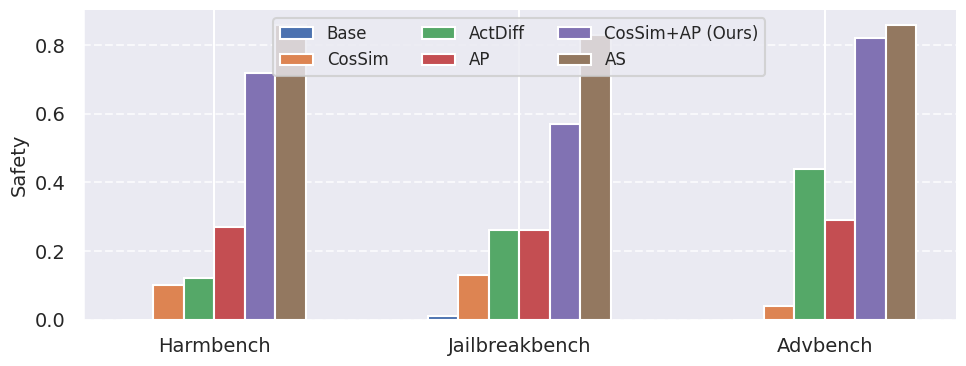

In [13]:
# Prepare data
import matplotlib.pyplot as plt
key_mapping = {
    'cs': 'CosSim',
    'act': 'ActDiff',
    'la': 'AP',
    'base': 'Base',
    'steer': 'AS',
    'our': 'CosSim+AP (Ours)',
}
outer_keys = ['base','cs', 'act', 'la','our','steer']
inner_keys = list(next(iter(combined_safety_scores.values())).keys())  # ['harmbench_test', 'jailbreakbench', 'advbench']

num_groups = len(inner_keys)
num_bars_per_group = len(outer_keys)

# Set positions
x = np.arange(num_groups)  # harmbench_test, jailbreakbench, advbench
bar_width = 0.1  # adjust as needed

# Create figure
fig, ax = plt.subplots(figsize=(10, 4))

# Plot each outer key as one series of bars
for i, outer_key in enumerate(outer_keys):
    values = [combined_safety_scores[outer_key][inner_key] for inner_key in inner_keys]
    ax.bar(x + i * bar_width, values, width=bar_width, label=key_mapping[outer_key])

# Configure x-axis
ax.set_xticks(x + bar_width * (num_bars_per_group - 1) / 2)
ax.set_xticklabels([x.capitalize().split('_')[0].strip() for x in inner_keys],fontsize=14)
# set y fontsize
ax.tick_params(axis='y', labelsize=14)
# ax.set_xlabel('Dataset')
ax.set_ylabel('Safety',fontsize=14)
# ax.set_title('Grouped Bar Plot')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(fontsize=12,ncol=3,loc = 'upper center')

# Add grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Plot both

In [ ]:
# load the other model as well
other_model = 'llama'
bm_dir = f'cache/benchmarks'
base_path = os.path.join(bm_dir,f'{other_model}_base.pkl')
combined_safety_scores2 = {}
with open(base_path,'rb') as f:
    base_scores = pickle.load(f)['jb']
combined_safety_scores2['base'] = base_scores

steer_path = os.path.join(bm_dir,f'{other_model}_steer.pkl')
with open(steer_path,'rb') as f:
    steer_scores = pickle.load(f)['jb']
combined_safety_scores2['steer'] = steer_scores

other_path = os.path.join(bm_dir,f'{other_model}_baseline.pkl')
with open(other_path,'rb') as f:
    baseline_jb_scores = pickle.load(f)['jb']

sorted_ = defaultdict(dict)
for k in ['cs','act','la','our']:
    for ok in baseline_jb_scores.keys():
        sorted_[k][ok] = baseline_jb_scores[ok][k]

combined_safety_scores2.update(sorted_)

for k,v in combined_safety_scores2.items():
    print (f"{k}: {v}")

base: {'harmbench_test': 0.12, 'jailbreakbench': 0.020000000000000018, 'advbench': 0.040000000000000036}
steer: {'harmbench_test': 0.9299999999999999, 'jailbreakbench': 0.91, 'advbench': 0.98}
cs: {'harmbench_test': 0.87, 'jailbreakbench': 0.87, 'advbench': 0.82}
act: {'harmbench_test': 0.45, 'jailbreakbench': 0.67, 'advbench': 0.77}
la: {'harmbench_test': 0.71, 'jailbreakbench': 0.63, 'advbench': 0.63}
our: {'harmbench_test': 0.82, 'jailbreakbench': 0.83, 'advbench': 0.74}


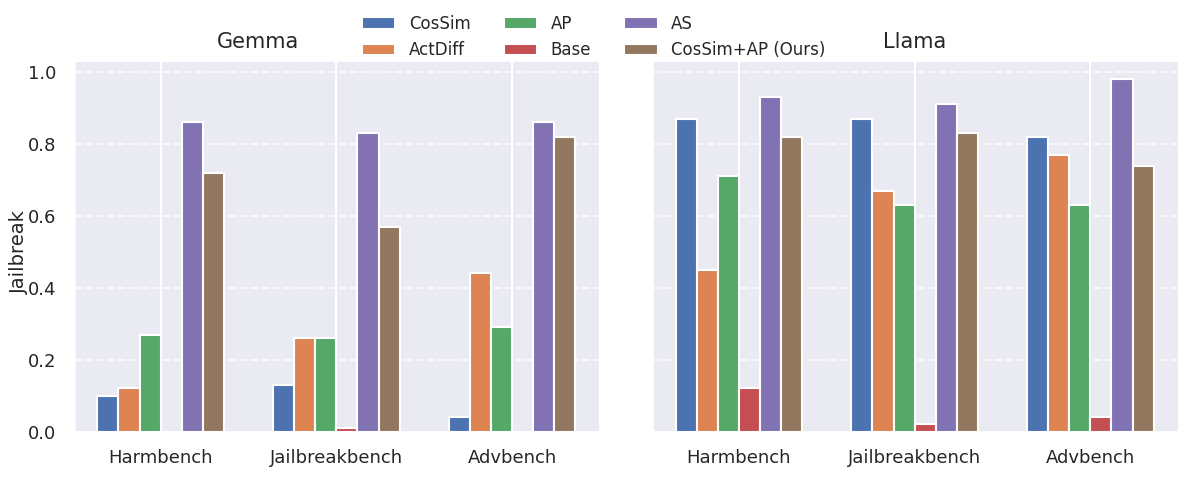

In [14]:
import seaborn as sns

inner_keys = list(next(iter(combined_safety_scores.values())).keys())  # ['harmbench_test', 'jailbreakbench', 'advbench']

# 1. Build tidy dataframe for plotting
def data_to_df(data, model_label):
    records = []
    for outer_key in outer_keys:
        for inner_key in inner_keys:
            records.append({
                "Method": key_mapping[outer_key],
                "Benchmark": inner_key.capitalize().split('_')[0],
                "Score": data[outer_key][inner_key],
                "Model": model_label
            })
    return pd.DataFrame(records)

df = pd.concat([
    data_to_df(combined_safety_scores2, "Llama"),
    data_to_df(combined_safety_scores, "Gemma")
])

# 2. Set seaborn style
sns.set(style="darkgrid", context="talk")

# 3. Plot grouped bars using barplot (loop over Models)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
models = ["Gemma", "Llama"]
colors = sns.color_palette("deep", n_colors=len(outer_keys))

for ax, model in zip(axes, models):
    df_sub = df[df["Model"] == model]
    # Draw each method's bars, with proper offset
    x = np.arange(len(inner_keys))
    bar_width = 0.12
    for i, method in enumerate(key_mapping.values()):
        vals = df_sub[df_sub["Method"] == method]["Score"].values
        ax.bar(x + i*bar_width, vals, width=bar_width, label=method, color=colors[i])
    ax.set_xticks(x + bar_width*(len(outer_keys)-1)/2)
    ax.set_xticklabels(df_sub["Benchmark"].unique(), fontsize=13)
    ax.set_title(model, fontsize=15, loc='center', pad=10)  # loc doesn't help with horizontal shifting
    if model == "Gemma":
        # Shift left by setting x < 0.5 (try 0.35 for a slight shift)
        ax.title.set_position([0.35, 1.05])  # x, y (y > 1 lifts above plot, adjust as needed)
    else:
        ax.title.set_position([0.5, 1.05])   # Keep Llama centered
    ax.tick_params(axis='y', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Shared y-axis label
fig.text(0.015, 0.5, 'Jailbreak', va='center', ha='center', rotation='vertical', fontsize=14)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12, frameon=False)

fig.subplots_adjust(left=0.06, right=0.98, top=0.88, bottom=0.14, wspace=0.10)
plt.show()

# 2) CE loss on Alpaca and The Pile

Load the Pile and Alpaca ds

In [43]:
ce_test_size = 1000 # take 1000 samples
pile_bz = 20
_, _, _, alpaca_ds = load_refusal_datasets(val_size=ce_test_size)  # take 500 for CE loss
num_pile_iter = ce_test_size//pile_bz
pile_iterator = load_pile_iterator(pile_bz,model.tokenizer,device=model.cfg.device)

Get the base responses for alpaca

In [ ]:
base_alpaca_outputs = batch_generate(alpaca_ds,model,bz = bz,saes=saes,steering_fn = None,max_new_tokens=256,use_tqdm=True)

16it [04:47, 17.99s/it]                                                                                                                


In [ ]:
# Get base ce loss
bz = 50

base_alpaca_loss = get_ce_loss(alpaca_ds,base_alpaca_outputs,bz,model,use_tqdm=True)
print (f'Base Alpaca CE Loss: {base_alpaca_loss:.3f}')

base_pile_loss = []
batch_no = 0
for pile_inputs,loss_mask in pile_iterator:
    if batch_no >= num_pile_iter:
        break
    base_pile_loss.append(get_input_ce_loss(pile_inputs,loss_mask,model))
    batch_no += 1
base_pile_loss = np.mean(base_pile_loss)
print (f'Base Pile CE Loss: {base_pile_loss:.3f}')

# do it for all the baselines
all_baseline_names = ['steer']+ list(baseline_feats.keys())  # add steer
baseline_alpaca_loss = {}
baseline_pile_loss = {}
for baseline_name in tqdm(all_baseline_names,total = len(all_baseline_names)):
    baseline_avg_loss = defaultdict(list) # just avg the loss over features found over different harm datasets (make it simpler)
    for harm_name in harm_ds.keys(): 
        model.reset_hooks()  # always reset
        to_hook_fn = None
        to_hook_args = None
        if baseline_name == 'steer':
            model.add_hook(resid_name_filter,partial(ablate_hook,vec = steering_vec[harm_name][best_layer]))
        else:
            fn_kwargs = {'ind':False,'val':clamp_val,'multiply':True}
            if baseline_name in ['cs','act']:
                feat_set = baseline_feats[baseline_name][harm_name]
            else:
                feat_set = global_feat_dict[baseline_name][harm_name] # take global feats
            model.add_hook(resid_name_filter,partial(clamp_sae,saes = saes, circuit = feat_set,**fn_kwargs))
        a_loss = get_ce_loss(alpaca_ds,base_alpaca_outputs,bz,model)

        p_loss = []
        batch_no = 0
        for pile_inputs,loss_mask in pile_iterator:
            if batch_no >= num_pile_iter:
                break
            p_loss.append(get_input_ce_loss(pile_inputs,loss_mask,model))
            batch_no += 1
        p_loss = np.mean(p_loss)
        baseline_avg_loss['alpaca'].append(a_loss)
        baseline_avg_loss['pile'].append(p_loss)
    
    baseline_alpaca_loss[baseline_name] = np.mean(baseline_avg_loss['alpaca'])
    baseline_pile_loss[baseline_name] = np.mean(baseline_avg_loss['pile'])

    print (f'Baseline ({baseline_name}) Alpaca CE Loss: {baseline_alpaca_loss[baseline_name]:.3f}')
    print (f'Baseline ({baseline_name}) Pile CE Loss: {baseline_pile_loss[baseline_name]:.3f}')
    
model.reset_hooks()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]


Base Alpaca CE Loss: 0.331
Base Pile CE Loss: 3.035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [14:22<00:00, 172.56s/it]


# Eval Refusal on Alpaca

In [ ]:
refusal_alpaca_ds = alpaca_ds[:100]
max_tokens = 100
sae_clamp_range = range(10,35,5)

refusal_alpaca_outputs = batch_generate(refusal_alpaca_ds,model,bz = bz,saes=saes,steering_fn = None,max_new_tokens=256,use_tqdm=True)

all_base_refusal = []
all_steer_refusal = []
sae_refusal_scores = defaultdict(lambda: defaultdict(list))


for dataset_name in tqdm(['harmbench_test','jailbreakbench','advbench'],total = 3):
    ## Base refusal score
    base_alpaca_gen = batch_generate(refusal_alpaca_ds,model,bz = bz,saes=saes,steering_fn = None,max_new_tokens=max_tokens)
    base_refusal_score = np.mean([substring_matching_judge_fn(x) for x in base_alpaca_gen])
    all_base_refusal.append(base_refusal_score)
    print (f'Base refusal score on {dataset_name}: {base_refusal_score:.2f}')

    ## Vec refusal score
    custom_steer_fn = partial(steer_hook,vec = steering_vec[dataset_name][best_layer]) # steer_hook adds the vec
    custom_steer_filter = lambda x: x == 'blocks.{l}.hook_resid_post'.format(l=best_layer) # only add in this layer.
    steer_alpaca_gen = batch_generate(refusal_alpaca_ds,model,bz = bz,steering_fn = 'custom',custom_fn =custom_steer_fn, max_new_tokens=max_tokens,custom_filter = custom_steer_filter)
    steer_refusal_score = np.mean([substring_matching_judge_fn(x) for x in steer_alpaca_gen])
    all_steer_refusal.append(steer_refusal_score)
    print (f'Steer refusal score on {dataset_name}: {steer_refusal_score:.2f}')

    for sae_baseline in baseline_feats.keys():
        if sae_baseline in ['cs','act']:
            feat_set = baseline_feats[sae_baseline][dataset_name]
        else:
            feat_set = global_feat_dict[sae_baseline][dataset_name]
        for clamp_val in sae_clamp_range:
            sae_alpaca_gen = batch_generate(refusal_alpaca_ds,model,bz = bz,saes=saes,steering_fn = 'sae',circuit = feat_set,fn_kwargs = {'val': clamp_val,'ind':False,'multiply':False},max_new_tokens=100)
            feat_refusal_score = np.mean([substring_matching_judge_fn(x) for x in sae_alpaca_gen])
            sae_refusal_scores[sae_baseline][clamp_val].append(feat_refusal_score)
        print (f'SAE ({sae_baseline}), : {sae_refusal_scores[sae_baseline]}')

avg_sae_refusal_scores = defaultdict(list)
for baseline_name,clamp_items in sae_refusal_scores.items():
    for clamp_value,scores in sorted(clamp_items.items(),key=lambda x: x[0]): # sort by clamp value
        avg_sae_refusal_scores[baseline_name].append(np.mean(scores))
            
all_base_refusal = np.mean(all_base_refusal)
all_steer_refusal = np.mean(all_steer_refusal)

all_alpaca_refusal_scores = {
    'base': all_base_refusal,
    'steer': all_steer_refusal,
    **avg_sae_refusal_scores
}
cache = os.path.join(bm_dir,f'{model_name}_refusal.pkl')
with open(cache,'wb') as f:
    pickle.dump(all_alpaca_refusal_scores,f)



  0%|                                                                                                           | 0/1 [00:00<?, ?it/s]

2it [00:37, 18.71s/it]                                                                                                                
  0%|                                                                                                           | 0/3 [00:00<?, ?it/s]

Base refusal score on harmbench_test: 0.01
Steer refusal score on harmbench_test: 0.99
SAE (cs), : defaultdict(<class 'list'>, {10: [0.01], 15: [0.02], 20: [0.03], 25: [0.1], 30: [0.17]})
SAE (act), : defaultdict(<class 'list'>, {10: [0.01], 15: [0.01], 20: [0.01], 25: [0.01], 30: [0.02]})
SAE (la), : defaultdict(<class 'list'>, {10: [0.02], 15: [0.01], 20: [0.01], 25: [0.02], 30: [0.03]})


 33%|████████████████████████████████▋                                                                 | 1/3 [05:34<11:08, 334.20s/it]

SAE (our), : defaultdict(<class 'list'>, {10: [0.13], 15: [0.46], 20: [0.82], 25: [0.98], 30: [1.0]})
Base refusal score on jailbreakbench: 0.01
Steer refusal score on jailbreakbench: 1.00
SAE (cs), : defaultdict(<class 'list'>, {10: [0.01, 0.01], 15: [0.02, 0.01], 20: [0.03, 0.04], 25: [0.1, 0.1], 30: [0.17, 0.22]})
SAE (act), : defaultdict(<class 'list'>, {10: [0.01, 0.01], 15: [0.01, 0.01], 20: [0.01, 0.01], 25: [0.01, 0.01], 30: [0.02, 0.01]})
SAE (la), : defaultdict(<class 'list'>, {10: [0.02, 0.02], 15: [0.01, 0.02], 20: [0.01, 0.01], 25: [0.02, 0.08], 30: [0.03, 0.15]})


 67%|█████████████████████████████████████████████████████████████████▎                                | 2/3 [10:49<05:23, 323.19s/it]

SAE (our), : defaultdict(<class 'list'>, {10: [0.13, 0.05], 15: [0.46, 0.23], 20: [0.82, 0.48], 25: [0.98, 0.78], 30: [1.0, 0.93]})
Base refusal score on advbench: 0.01
Steer refusal score on advbench: 1.00
SAE (cs), : defaultdict(<class 'list'>, {10: [0.01, 0.01, 0.01], 15: [0.02, 0.01, 0.01], 20: [0.03, 0.04, 0.04], 25: [0.1, 0.1, 0.1], 30: [0.17, 0.22, 0.22]})
SAE (act), : defaultdict(<class 'list'>, {10: [0.01, 0.01, 0.01], 15: [0.01, 0.01, 0.01], 20: [0.01, 0.01, 0.01], 25: [0.01, 0.01, 0.01], 30: [0.02, 0.01, 0.01]})
SAE (la), : defaultdict(<class 'list'>, {10: [0.02, 0.02, 0.01], 15: [0.01, 0.02, 0.01], 20: [0.01, 0.01, 0.01], 25: [0.02, 0.08, 0.02], 30: [0.03, 0.15, 0.03]})


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [15:58<00:00, 319.56s/it]

SAE (our), : defaultdict(<class 'list'>, {10: [0.13, 0.05, 0.23], 15: [0.46, 0.23, 0.67], 20: [0.82, 0.48, 0.97], 25: [0.98, 0.78, 1.0], 30: [1.0, 0.93, 0.99]})


In [ ]:
## plot single model
plot_line_mpl(list(avg_sae_refusal_scores.values()),xlabel = 'Clamp',ylabel = 'Refusal',x_tick = [str(x) for x in list(sae_clamp_range)],hlines = [all_base_refusal,all_steer_refusal],hline_labels = ['Base','Steer'],labels = ['CosSim','ActDiff','AP','CosSim+AP (Ours)'],figsize = (12,6))

In [ ]:
# plot double model
other_model = 'llama'
other_model_path = os.path.join(bm_dir,f'{other_model}_refusal.pkl')

with open(other_model_path,'rb') as f:
    other_model_refusal_scores = pickle.load(f)

all_alpaca_refusal_scores['base'] = [all_alpaca_refusal_scores['base']]*len(sae_clamp_range)
all_alpaca_refusal_scores['steer'] = [all_alpaca_refusal_scores['steer']]*len(sae_clamp_range)

other_model_refusal_scores['base'] = [other_model_refusal_scores['base']]*len(sae_clamp_range)
other_model_refusal_scores['steer'] = [other_model_refusal_scores['steer']]*len(sae_clamp_range)

data_list = [list(all_alpaca_refusal_scores.values()),list(other_model_refusal_scores.values())]
figsize = (14,5)

x_ticks = [list(range(10,35,5)),list(range(1,6))]

labels = [['Base','AS','CosSim','ActDiff','AP','CosSim+AP (Ours)']]*2
xlabel = 'Clamp Value'
ylabel = 'Refusal'
titles = ['Gemma','Llama']

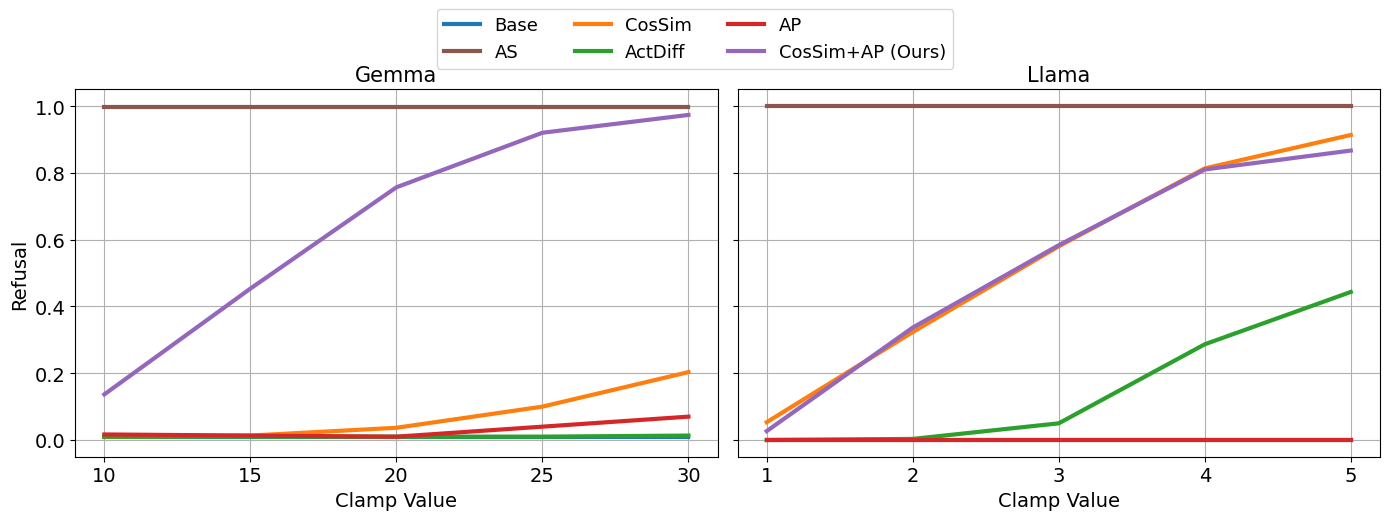

In [115]:
assert len(data_list) == 2, "This function supports exactly two subplots."

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

label_color_map = {
    'Base': '#1f77b4',           # blue
    'CosSim': '#ff7f0e',         # orange
    'ActDiff': '#2ca02c',        # green
    'AP': '#d62728',             # red
    'CosSim+AP (Ours)': '#9467bd',  # purple
    'AS': '#8c564b'              # brown
}

# Collect handles for shared legend
legend_handles = []
legend_labels = []

for i, data in enumerate(data_list):
    ax = axes[i]
    data = np.array(data)
    if data.ndim == 1:
        data = data.reshape(1, -1)

    x_tick_i = x_ticks[i]

    # Plot data lines
    for j, d in enumerate(data):
        lbl = labels[i][j] if labels is not None else None
        line, = ax.plot(x_tick_i, d, label=lbl, linewidth=3,color = label_color_map[lbl])
        if i == 0:  # Only collect from the first subplot to avoid duplicates
            legend_handles.append(line)
            legend_labels.append(lbl)


    ax.set_xlabel(xlabel, fontsize=14)
    if i == 0:
        ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x_tick_i)
    ax.tick_params(axis='both', labelsize=14)

    if titles:
        ax.set_title(titles[i], fontsize=15)

    ax.grid(True)

# Shared legend
fig.legend(legend_handles, legend_labels, loc='upper center',
            ncol=3, fontsize=13, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()

# General capabilities (GSM8K/ARC)

In [41]:
from utils.eval_capability import *
gsm8k_ds = load_gsm8k()
arc_ds = load_arc()

In [ ]:
gsm8k_bz = 16
arc_bz = 32

gsm8k_string = {}

## Base gsm8k
model.reset_hooks()
base_string = eval_gsm8k(gsm8k_ds,model,gsm8k_bz,use_tqdm=True)
gsm8k_string['base'] = base_string
print (f'Base GSM8K string acc: {base_string:.2f}')

# baselines
all_baseline_names = ['steer']+ list(baseline_feats.keys())  # add steer
for baseline_name in tqdm(all_baseline_names,total = len(all_baseline_names)):
    all_gsm8k_string = []
    for harm_name in harm_ds.keys(): 
        model.reset_hooks()
        if baseline_name == 'steer':
            model.add_hook(resid_name_filter,partial(ablate_hook,vec = steering_vec[harm_name][best_layer]))
        else:
            fn_kwargs = {'ind':False,'val':clamp_val,'multiply':True}
            if baseline_name in ['cs','act']:
                feat_set = baseline_feats[baseline_name][harm_name]
            else:
                feat_set = global_feat_dict[baseline_name][harm_name] # take global feats
            model.add_hook(resid_name_filter,partial(clamp_sae,saes = saes, circuit = feat_set,**fn_kwargs))
        
        baseline_string = eval_gsm8k(gsm8k_ds,model,gsm8k_bz,use_tqdm=True)
        all_gsm8k_string.append(baseline_string)
    gsm8k_string[baseline_name] = np.mean(all_gsm8k_string)
model.reset_hooks()

for k,v in gsm8k_string.items():
    print (f'{k} Acc: {v:.2f}')



In [ ]:
model.reset_hooks()
arc_scores = {}
arc_scores['base'] = eval_arc(arc_ds,model,arc_bz,use_tqdm=True)

all_baseline_names = ['steer']+ list(baseline_feats.keys())  # add steer
for baseline_name in tqdm(all_baseline_names,total = len(all_baseline_names)):
    all_arc_scores = []
    for harm_name in harm_ds.keys(): 
        model.reset_hooks()
        if baseline_name == 'steer':
            model.add_hook(resid_name_filter,partial(ablate_hook,vec = steering_vec[harm_name][best_layer]))
        else:
            fn_kwargs = {'ind':False,'val':clamp_val,'multiply':True}
            if baseline_name in ['cs','act']:
                feat_set = baseline_feats[baseline_name][harm_name]
            else:
                feat_set = global_feat_dict[baseline_name][harm_name] # take global feats
            model.add_hook(resid_name_filter,partial(clamp_sae,saes = saes, circuit = feat_set,**fn_kwargs))
        all_arc_scores.append(eval_arc(arc_ds,model,arc_bz,use_tqdm=False))
    arc_scores[baseline_name] = np.mean(all_arc_scores)
model.reset_hooks()

for k,v in arc_scores.items():
    print (f'{k} ARC acc: {v:.2f}')

37it [00:30,  1.21it/s]                                                                                                             
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:50<00:00, 58.17s/it]

base ARC acc: 0.82
steer ARC acc: 0.81
cs ARC acc: 0.78
act ARC acc: 0.79
la ARC acc: 0.79
our ARC acc: 0.77
